In [1]:
import pandas as pd
import numpy as np
import re
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [3]:
# Load dataset
FILE_PATH = "IndianFinancialNews_with_sentiment.csv"
df = pd.read_csv(FILE_PATH)

In [5]:
# ------------------------- #
# 🔹 Text Preprocessing
# ------------------------- #
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df["Cleaned_Text"] = df["Text"].apply(clean_text)

In [7]:
# ------------------------- #
# 🔹 Convert Labels to Numeric
# ------------------------- #
label_mapping = {"positive": 1, "negative": 0, "neutral": 2}
df["Sentiment_Label"] = df["Sentiment"].map(label_mapping)

In [9]:
# ------------------------- #
# 🔹 Tokenization & Padding
# ------------------------- #
MAX_WORDS = 10000  # Vocabulary size
MAX_LEN = 100  # Max length of each news article

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df["Cleaned_Text"])

In [11]:
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df["Cleaned_Text"])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding="post", truncating="post")

In [13]:
# ------------------------- #
# 🔹 Train-Test Split
# ------------------------- #
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df["Sentiment_Label"], test_size=0.2, random_state=42)

In [15]:
# Save Tokenizer for future use
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [20]:
# Save preprocessed data
np.savez_compressed("preprocessed_data.npz", X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

print(f"Preprocessing complete! Data saved as 'preprocessed_data.npz'")

Preprocessing complete! Data saved as 'preprocessed_data.npz'


How to Run the Script and check the output


**Train LSTM Model for Sentiment Analysis**

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pickle

In [24]:
# ------------------------- #
# 🔹 Load Preprocessed Data
# ------------------------- #
data = np.load("preprocessed_data.npz")
X_train, X_test, y_train, y_test = data["X_train"], data["X_test"], data["y_train"], data["y_test"]


In [26]:
# Load Tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

VOCAB_SIZE = 10000  # Same as in preprocessing
MAX_LEN = 100  # Same as in preprocessing
EMBEDDING_DIM = 128  # Word embedding size

In [28]:
# ------------------------- #
# 🔹 Define LSTM Model
# ------------------------- #
model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")  # 3 classes: positive, negative, neutral
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
# ------------------------- #
# 🔹 Convert Labels to Numeric
# ------------------------- #
label_mapping = {"positive": 2, "negative": 0, "neutral": 1}  # Changed mapping
df["Sentiment_Label"] = df["Sentiment"].map(label_mapping)

In [32]:
# ------------------------- #
# 🔹 Train the Model
# ------------------------- #
EPOCHS = 10
BATCH_SIZE = 32

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 104s 83ms/step - accuracy: 0.4718 - loss: 1.0587 - val_accuracy: 0.4716 - val_loss: 1.0558
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.4719 - loss: 1.0562 - val_accuracy: 0.4716 - val_loss: 1.0548
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 93s 74ms/step - accuracy: 0.4698 - loss: 1.0566 - val_accuracy: 0.4716 - val_loss: 1.0547
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 96s 77ms/step - accuracy: 0.4721 - loss: 1.0543 - val_accuracy: 0.4716 - val_loss: 1.0550
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 94s 75ms/step - accuracy: 0.4688 - loss: 1.0571 - val_accuracy: 0.4716 - val_loss: 1.0551
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 77ms/step - accuracy: 0.4729 - loss: 1.0540 - val_accuracy: 0.4716 - val_loss: 1.0547
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 97s 78ms/step - accuracy: 0.4694 - loss: 1.0557 - val_accuracy: 0.4716 - val_loss: 1.0547
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 93s 75ms/step - accuracy: 0.4721 

In [34]:
# ------------------------- #
# 🔹 Save the Model
# ------------------------- #
model.save("lstm_sentiment_model.h5")

print("✅ LSTM model training complete! Model saved as 'lstm_sentiment_model.h5'")

✅ LSTM model training complete! Model saved as 'lstm_sentiment_model.h5'


**Evaluate LSTM Model**

In [36]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [38]:
# ------------------------- #
# 🔹 Load Model & Data
# ------------------------- #
# Load preprocessed data
data = np.load("preprocessed_data.npz")
X_test, y_test = data["X_test"], data["y_test"]

# Load trained LSTM model
model = tf.keras.models.load_model("lstm_sentiment_model.h5")

In [40]:
# ------------------------- #
# 🔹 Make Predictions
# ------------------------- #
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


In [42]:
# ------------------------- #
# 🔹 Evaluate Model
# ------------------------- #
print("LSTM Model Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive", "Neutral"]))

LSTM Model Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      2353
    Positive       0.47      1.00      0.64      4716
     Neutral       0.00      0.00      0.00      2931

    accuracy                           0.47     10000
   macro avg       0.16      0.33      0.21     10000
weighted avg       0.22      0.47      0.30     10000



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


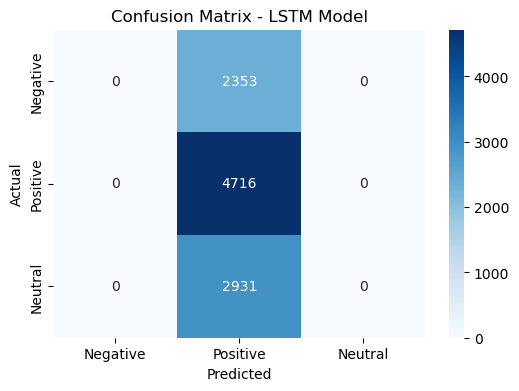

In [44]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# ------------------------- #
# 🔹 Plot Confusion Matrix
# ------------------------- #
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive", "Neutral"], yticklabels=["Negative", "Positive", "Neutral"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LSTM Model")
plt.show()

**Train CNN Model for Sentiment Analysis**

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pickle

In [48]:
# ------------------------- #
# 🔹 Load Preprocessed Data
# ------------------------- #
data = np.load("preprocessed_data.npz")
X_train, X_test, y_train, y_test = data["X_train"], data["X_test"], data["y_train"], data["y_test"]

In [50]:
# Load Tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

VOCAB_SIZE = 10000  # Same as in preprocessing
MAX_LEN = 100  # Same as in preprocessing
EMBEDDING_DIM = 128  # Word embedding size

In [52]:
# ------------------------- #
# 🔹 Define CNN Model
# ------------------------- #
model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),
    Conv1D(filters=128, kernel_size=5, activation="relu"),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(3, activation="softmax")  # 3 classes: positive, negative, neutral
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [54]:
# ------------------------- #
# 🔹 Train the Model
# ------------------------- #
EPOCHS = 10
BATCH_SIZE = 32

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.6969 - loss: 0.6880 - val_accuracy: 0.9207 - val_loss: 0.2613
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9370 - loss: 0.2098 - val_accuracy: 0.9329 - val_loss: 0.2297
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.9601 - loss: 0.1276 - val_accuracy: 0.9289 - val_loss: 0.2617
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.9697 - loss: 0.0936 - val_accuracy: 0.9303 - val_loss: 0.2944
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.9781 - loss: 0.0675 - val_accuracy: 0.9300 - val_loss: 0.2997
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9813 - loss: 0.0527 - val_accuracy: 0.9258 - val_loss: 0.3547
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.9842 - loss: 0.0475 - val_accuracy: 0.9210 - val_loss: 0.4144
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9869 -

In [56]:
# ------------------------- #
# 🔹 Save the Model
# ------------------------- #
model.save("cnn_sentiment_model.h5")

print("✅ CNN model training complete! Model saved as 'cnn_sentiment_model.h5'")

✅ CNN model training complete! Model saved as 'cnn_sentiment_model.h5'


**Evaluate CNN Model with Confusion Matrix**

In [58]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [60]:
# ------------------------- #
# 🔹 Load Model & Data
# ------------------------- #
# Load preprocessed data
data = np.load("preprocessed_data.npz")
X_test, y_test = data["X_test"], data["y_test"]

# Load trained CNN model
model = tf.keras.models.load_model("cnn_sentiment_model.h5")

In [62]:
# ------------------------- #
# 🔹 Make Predictions
# ------------------------- #
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [64]:
# 🔹 Evaluate Model
# ------------------------- #
print("CNN Model Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive", "Neutral"]))

CNN Model Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.89      0.88      2353
    Positive       0.95      0.92      0.93      4716
     Neutral       0.86      0.91      0.89      2931

    accuracy                           0.91     10000
   macro avg       0.90      0.91      0.90     10000
weighted avg       0.91      0.91      0.91     10000



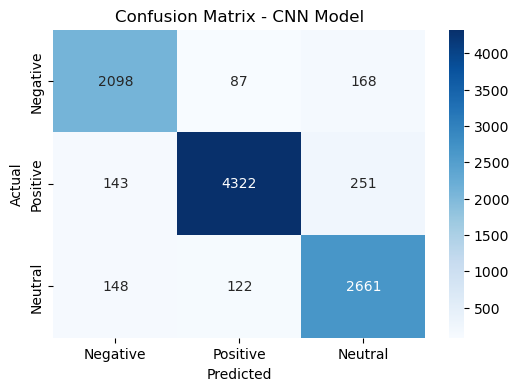

In [66]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# ------------------------- #
# 🔹 Plot Confusion Matrix
# ------------------------- #
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive", "Neutral"], yticklabels=["Negative", "Positive", "Neutral"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN Model")
plt.show()